# Tema 4: Hadamard Test

En este notebook vamos a implementar el **Hadamard Test**, un algoritmo cuántico fundamental que nos permite estimar la parte real e imaginaria del valor esperado de un operador unitario U aplicado a un estado cuántico |ψ⟩.

El Hadamard Test es especialmente útil porque nos permite calcular ⟨ψ|U|ψ⟩ de forma eficiente utilizando un qubit auxiliar (ancilla) y mediciones en la base computacional.

**¿Qué vamos a hacer?**
- Implementar el circuito del Hadamard Test para diferentes operadores unitarios
- Calcular tanto la parte real como la imaginaria del valor esperado
- Visualizar y analizar los resultados obtenidos

**Aplicaciones:**
El Hadamard Test es un componente clave en muchos algoritmos cuánticos, incluyendo algoritmos de estimación de fase, cálculo de productos internos entre estados cuánticos, y evaluación de propiedades de sistemas cuánticos.

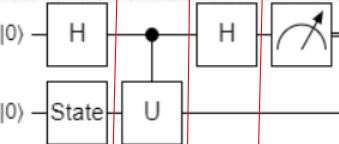


## **¿Cómo funciona el Hadamard Test?**
El circuito del Hadamard Test nos permite extraer información sobre ⟨ψ|U|ψ⟩ midiendo el qubit ancilla. Veamos cómo:

1. **Estado inicial**: Comenzamos con el qubit ancilla en |0⟩ y los qubits objetivo en el estado |ψ⟩:
   $$|0⟩_{anc} \otimes |\psi⟩$$

2. **Primera puerta Hadamard**: Aplicamos H al ancilla, creando una superposición:
   $$\frac{1}{\sqrt{2}}(|0⟩ + |1⟩)_{anc} \otimes |\psi⟩$$

3. **Control-U**: Aplicamos el operador U controlado por el ancilla. Cuando el ancilla está en |0⟩, no se aplica nada; cuando está en |1⟩, se aplica U:
   $$\frac{1}{\sqrt{2}}(|0⟩ \otimes |\psi⟩ + |1⟩ \otimes U|\psi⟩)$$

4. **Segunda puerta Hadamard**: Aplicamos H nuevamente al ancilla. Esto es clave para la interferencia:
   $$\frac{1}{2}[(|0⟩ + |1⟩) \otimes |\psi⟩ + (|0⟩ - |1⟩) \otimes U|\psi⟩]$$
   
   Reagrupando términos:
   $$\frac{1}{2}[|0⟩ \otimes (|\psi⟩ + U|\psi⟩) + |1⟩ \otimes (|\psi⟩ - U|\psi⟩)]$$

5. **Probabilidad de medir |0⟩**: La probabilidad de medir el ancilla en |0⟩ es:
   $$P(0) = \frac{1}{4}||(|\psi⟩ + U|\psi⟩)||^2 = \frac{1}{4}(\langle\psi| + \langle\psi|U^\dagger)(|\psi⟩ + U|\psi⟩)$$
   
   Expandiendo:
   $$P(0) = \frac{1}{4}[\langle\psi|\psi⟩ + \langle\psi|U|\psi⟩ + \langle\psi|U^\dagger|\psi⟩ + \langle\psi|U^\dagger U|\psi⟩]$$
   
   Como U es unitario (U†U = I) y |ψ⟩ está normalizado (⟨ψ|ψ⟩ = 1):
   $$P(0) = \frac{1}{4}[1 + \langle\psi|U|\psi⟩ + \langle\psi|U^\dagger|\psi⟩ + 1] = \frac{1}{2}[1 + \text{Re}(\langle\psi|U|\psi⟩)]$$
   
   Por lo tanto:
   $$\text{Re}(\langle\psi|U|\psi⟩) = 2P(0) - 1$$

**Para la parte imaginaria**: Si aplicamos una puerta S† (rotación de fase de -π/2) antes de la segunda Hadamard, obtenemos:
$$\text{Im}(\langle\psi|U|\psi⟩) = 2P(0) - 1$$

De esta manera, midiendo el qubit ancilla y calculando la frecuencia de obtener |0⟩, podemos estimar tanto la parte real como la imaginaria de ⟨ψ|U|ψ⟩.

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

---
# Circuito cuántico

Para implementar el circuito del Hadamard Test, necesitamos:

- **n qubits objetivo**: Estos qubits contendrán el estado cuántico |ψ⟩ sobre el que queremos aplicar el operador U
- **1 qubit ancilla**: Este qubit auxiliar es fundamental para el Hadamard Test, ya que nos permitirá extraer información sobre ⟨ψ|U|ψ⟩ mediante mediciones

Vamos a crear una función `Hadamard_Circuit` que reciba los siguientes parámetros:
- `n`: número de qubits objetivo
- `state`: el estado cuántico |ψ⟩ que queremos preparar
- `U`: el operador unitario que queremos evaluar
- `Re`: un parámetro booleano para seleccionar si queremos calcular la parte real (Re=True) o la parte imaginaria (Re=False) del valor esperado

La diferencia entre calcular la parte real o imaginaria está en aplicar una puerta S† adicional antes de la segunda puerta Hadamard en el qubit ancilla.

In [2]:
def Hadamard_Circuit(n:int, state, U, Re: bool=True):
    #Registros
    anc = QuantumRegister(1, 'ancilla')
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(1, 'c')

    #Circuito
    qc = QuantumCircuit(anc, qr, cr, name='Hadamard')

    #H en la ancilla
    qc.h(anc[0])

    #Inicializamos el estado, también podemos usar StatePreparation
    qc.initialize(state, qubits=qr[:], normalize=True)

    #Control-U (otra forma de definirlo)
    controlU = U.control(1)
    qc.append(controlU, range(n+1))
    qc.barrier()

    #Para la parte imaginaria
    if Re == False:
        qc.sdg(anc[0])

    #H en ancilla
    qc.h(anc[0])

    #Mediciones
    qc.measure(anc[0],0)

    #Esto es por visualización
    decomp_qc = qc.decompose(['State_Preparation', 'c_U', 'U'], reps=1)

    return decomp_qc

Ahora definamos un operador para introducir.  Vamos a probar uno usualmente utilizado:
$$U = \mathbb{I}\otimes Z\otimes\mathbb{I}$$

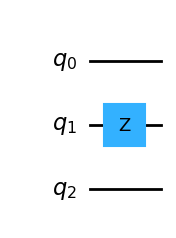

In [3]:
n = 3

#Registros
qr = QuantumRegister(n, 'q')

U = QuantumCircuit(qr, name='U')

#Puertas
U.z(1)

U.draw('mpl')

Convertimos el U en una gate.

In [4]:
U_gate = U.to_gate()

Creamos un circuito cuántico de esos n qubits.

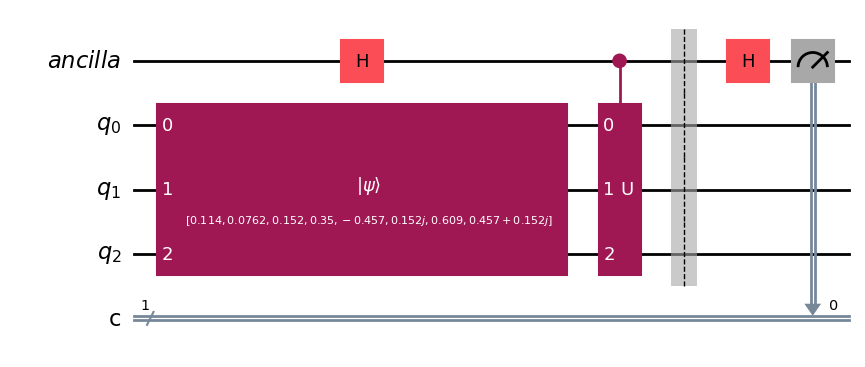

In [5]:
#Vector de estado
state = np.array([0.75, 0.5, 1, 2.3, -3, 1j, 4, 3+1j])
state /= np.sqrt(sum(state*np.conjugate(state)))

qcRe = Hadamard_Circuit(n, state, U)

qcRe.draw('mpl')

### Ejercicio

Prueba a buscar la componente imaginaria y llámalo qcIm.

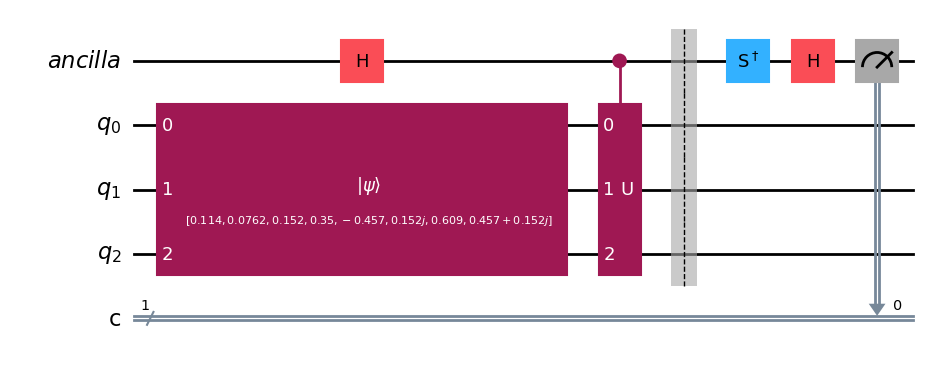

In [6]:
#Vector de estado
state = np.array([0.75, 0.5, 1, 2.3, -3, 1j, 4, 3+1j])
state /= np.sqrt(sum(state*np.conjugate(state)))

qcIm = Hadamard_Circuit(n, state, U, Re=False)

qcIm.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

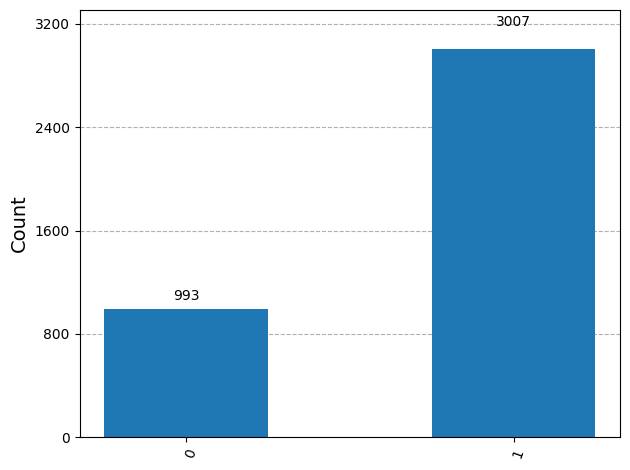

In [7]:
#Simulador de n+1 qubits
backend = AerSimulator()  # n+1)

#Transpilamos
qc_transpiled = transpile(qcRe, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=4000)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vamos a calcular la parte real del valor esperado del operador $U$ a partir de las probabilidades de medición obtenidas.

Recordemos que en el test de Hadamard, la probabilidad de medir el qubit auxiliar en el estado $|0\rangle$ está directamente relacionada con la parte real del valor esperado. Específicamente, esta probabilidad viene dada por:

$$P(0) = \frac{1 + Re(\langle U \rangle)}{2}$$

Despejando de esta expresión, obtenemos la parte real del valor esperado:

$$Re(\langle U \rangle) = 2P(0) - 1$$

donde $P(0)$ se calcula como la fracción de mediciones que resultaron en '0' sobre el total de mediciones realizadas.


In [8]:
Re_U = 2* ( counts['0']/(counts['0']+counts['1'] )) - 1
Re_U

-0.5035000000000001

Ahora la parte imaginaria.

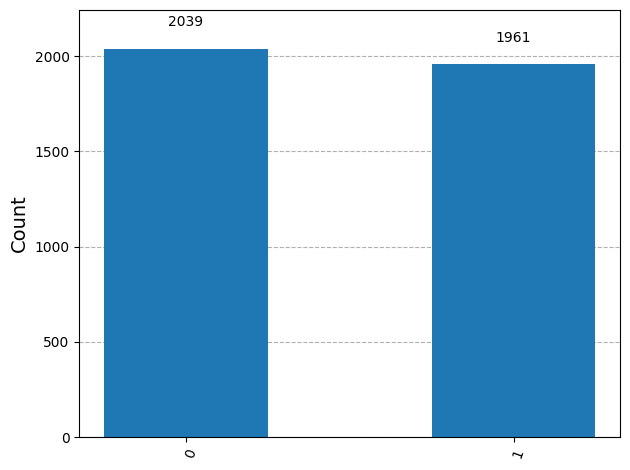

In [9]:
qc_transpiled = transpile(qcIm, backend)

#Creamos el job
job = backend.run(qc_transpiled, shots=4000)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

In [10]:
Im_U = 2* ( counts['0']/(counts['0']+counts['1'] )) - 1
Im_U

0.019500000000000073

Clásicamente sería

In [11]:
I = np.eye(2)
Z = np.array([[1,0],[0,-1]])

U = np.kron(np.kron(I,Z),I)

print('Cuántico: ', Re_U+Im_U*1j)
print('Exacto:   ', np.conjugate(state) @ U @ state)

Cuántico:  (-0.5035000000000001+0.019500000000000073j)
Exacto:    (-0.4982889623571719+0j)


Vemos que es consistente, aunque con un pequeño error debido al número limitado de shots.

---
# Prueba con otro operador

Ahora haz un circuito para otro estado y operador y pruébalo con diferente número de shots para ver la precisión.

In [12]:
n = 3

#Registros
qr = QuantumRegister(n, 'q')

U = QuantumCircuit(qr, name='U')

#Puertas
U.s(1)

U_gate = U.to_gate()

#Vector de estado
state = np.array([0.75+0.1j, 0.5-0.2j, 1-1j, 2.3+0.25j, -3-0.43j, 1j-0.4j, 4+2j, 3+1j])
state /= np.sqrt(sum(state*np.conjugate(state)))

qcRe = Hadamard_Circuit(n, state, U)
qcIm = Hadamard_Circuit(n, state, U, False)

backend = AerSimulator()  # n+1)

#Parte real
qc_transpiled = transpile(qcRe, backend)

#Creamos el job
job = backend.run(qc_transpiled, shots=4000)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()

Re_U = 2* ( counts['0']/(counts['0']+counts['1'] )) - 1

#Parte imaginaria
qc_transpiled = transpile(qcIm, backend)

#Creamos el job
job = backend.run(qc_transpiled, shots=4000)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()

Im_U = 2* ( counts['0']/(counts['0']+counts['1'] )) - 1

#Clásico
I = np.eye(2)
S = np.array([[1,0],[0,1j]])

U_matriz = np.kron(np.kron(I,S),I)

print('Cuántico: ', Re_U+1j*Im_U)
print('Exacto:   ', np.conjugate(state) @ U_matriz @ state)

Cuántico:  (0.21550000000000002+0.778j)
Exacto:    (0.21791084152186246+0.7820891584781373j)


A más shots, mayor precisión.